In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime
from tqdm import tqdm
sns.set_theme(palette="RdBu", style="darkgrid")

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
df = pd.read_csv("real_estate_data_sample.csv",
                 delimiter='\t')

/var/folders/6q/bp8zcmjx7_d5s99yfjlq82540000gn/T/ipykernel_13752/2501695901.py:1: DtypeWarning: Columns (66,68,111,113,156,158) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("real_estate_data_sample.csv",


In [5]:
df.head()

,orig_intrt,orig_upb,loan_term,orig_dt,pay_dt_1,orig_ltv,orig_cltv,dbt_incm_ratio,borr_crdt_score,FirstTime_buyer,...,zero_bal_date122014,int_rate122015,unpaid_prncpl_bal122015,loan_age122015,mnths_to_maturity122015,maturity_dt122015,msa122015,delinq_status122015,zero_bal_code122015,zero_bal_date122015
0,4.625,280000,360,02/2012,04/2012,31,31,23.0,801.0,N,...,NaN,4.625,262326.1,45.0,315.0,03/2042,41860.0,0,NaN,NaN
1,3.990,466000,360,01/2012,03/2012,80,80,30.0,794.0,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.000,229000,360,02/2012,04/2012,67,67,36.0,802.0,N,...,NaN,4.000,212777.0,45.0,315.0,03/2042,49700.0,0,NaN,NaN
3,4.125,154000,360,12/2011,02/2012,77,77,43.0,724.0,N,...,NaN,4.125,142350.7,47.0,313.0,01/2042,14460.0,0,NaN,NaN
4,3.875,152000,360,01/2012,03/2012,48,48,26.0,820.0,N,...,NaN,3.875,140821.5,46.0,314.0,02/2042,40140.0,0,NaN,NaN


In [6]:
df = df.reset_index().rename(columns={"index": "idx"})

In [7]:
# Change data format
df["orig_dt"] = df["orig_dt"].apply(lambda x: datetime.strptime(x, "%m/%Y")) # Origination Date
df["first_pay_t"] = df["pay_dt_1"].apply(lambda x: datetime.strptime(x, "%m/%Y")) # First Payment Date
df["idx"] = df["idx"].astype(int).astype(str)

__First analyze data...__

In [289]:
print("Start: ", df.orig_dt.unique().max())
print("End: ", df.orig_dt.unique().min())

Start:  2012-03-01T00:00:00.000000000
End:  2010-12-01T00:00:00.000000000


In [290]:
n_bonds = df.shape[0]

In [ ]:
def getAnalysisData(prefix):
    
    '''Extract a subset of the dataset in long format'''

    id_cols = ["idx", "orig_dt"]
    var_cols = df.columns[df.columns.str.startswith(prefix)].to_list()
    cols = id_cols + var_cols

    data = df[cols].copy()

    # get a long dataframe
    data = (data.set_index(id_cols).stack().reset_index()
           .rename(columns = {"level_2": "perform_record", 0: prefix}))
    
    # get record date
    data["perform_dt"] = ( data["perform_record"]
                      .apply(lambda x: re.findall(f"(?<={prefix})\d+", x)[0])
                      .apply(lambda x: datetime.strptime(x, "%m%Y")) )
    
    return data

# Question 1

Calculate the fraction of loans that prepay in the first two years of their life.
 
Plot the mean cumulative prepayment rate where x-axis are months since loan origination. So the value in say 10 month will be the percentage of loans that prepaid by the tenth month from their origination

In [446]:
# get zero balance data
bal = getAnalysisData(prefix="zero_bal_code")
bal = bal.sort_values(by=["idx", "orig_dt"])

# filter
isprepaid = bal.zero_bal_code.isin([1])
in2y = (bal.perform_dt - bal.orig_dt).apply(lambda x: x.days) <= 730

print("Fraction of loans that prepay in the first two years of their life:",
      f"{len(bal.loc[isprepaid & in2y].idx.unique()) / n_bonds *100:.2f}%")

Fraction of loans that prepay in the first two years of their life: 21.12%


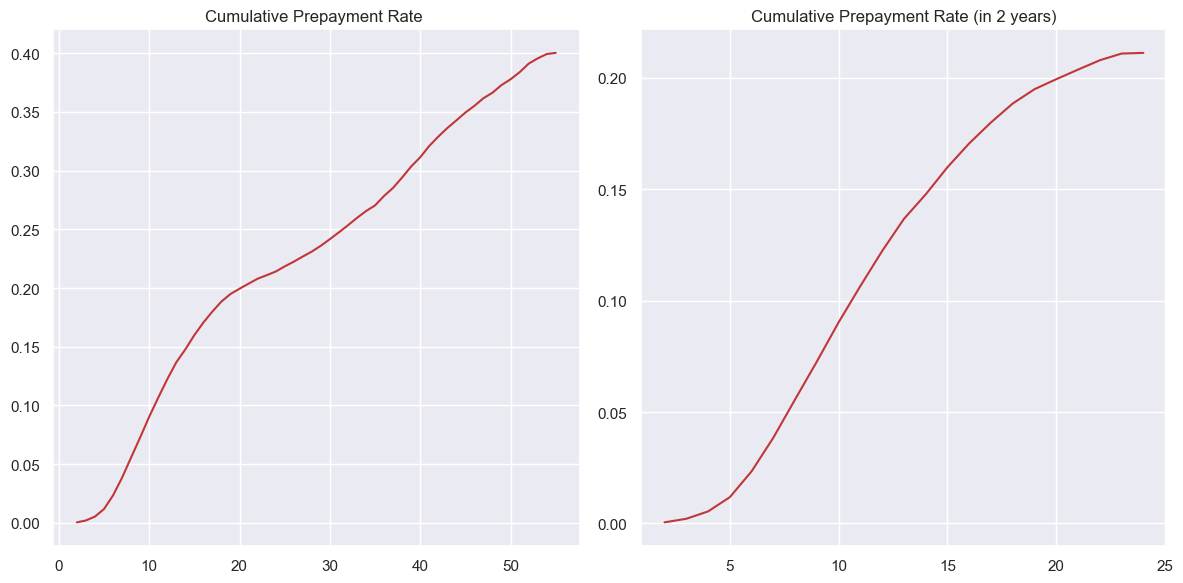

In [449]:
bal["month_since_org"] = (bal["perform_dt"] - bal["orig_dt"]).apply(lambda x: x.days // 30)

# mark
prepay_idx = bal[isprepaid].drop_duplicates(subset=["idx"], keep="first")
prepay2y_idx = bal[isprepaid & in2y].drop_duplicates(subset=["idx"], keep="first")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].plot(prepay_idx.groupby("month_since_org").size().cumsum()/n_bonds)
axes[0].set_title("Cumulative Prepayment Rate ")

axes[1].plot(prepay2y_idx.groupby("month_since_org").size().cumsum()/n_bonds)
axes[1].set_title("Cumulative Prepayment Rate (in 2 years)")

plt.tight_layout()
plt.show()

## Question 2
Calculate the fraction of loans that default in the first two years of their life. Assume that the default is an absorbing state and happens when a loan becomes 60 days past due on its payments. 

Plot the cumulative default rate where x-axis are months since origination. So the value in say 10 month will be the percentage of loans that become ever 60 days past due on their payments by the tenth month since their origination.

In [453]:
# get delinq status data
delinq = getAnalysisData("delinq_status")
delinq = delinq.sort_values(by=["idx", "orig_dt"])

# filter
isdefault = delinq.delinq_status.isin(['2']) # ~tmp.delinq_status.isin([0, 1, '0', '1', 'X'])
in2y = (delinq.perform_dt - delinq.orig_dt).apply(lambda x: x.days) <= 730

# calculate fraction
print("Fraction of loans that default in the first two years of their life: ",
      f"{ len( delinq[isdefault & in2y].idx.unique() ) / n_bonds * 100:.2f} %")

Fraction of loans that default in the first two years of their life:  0.32 %


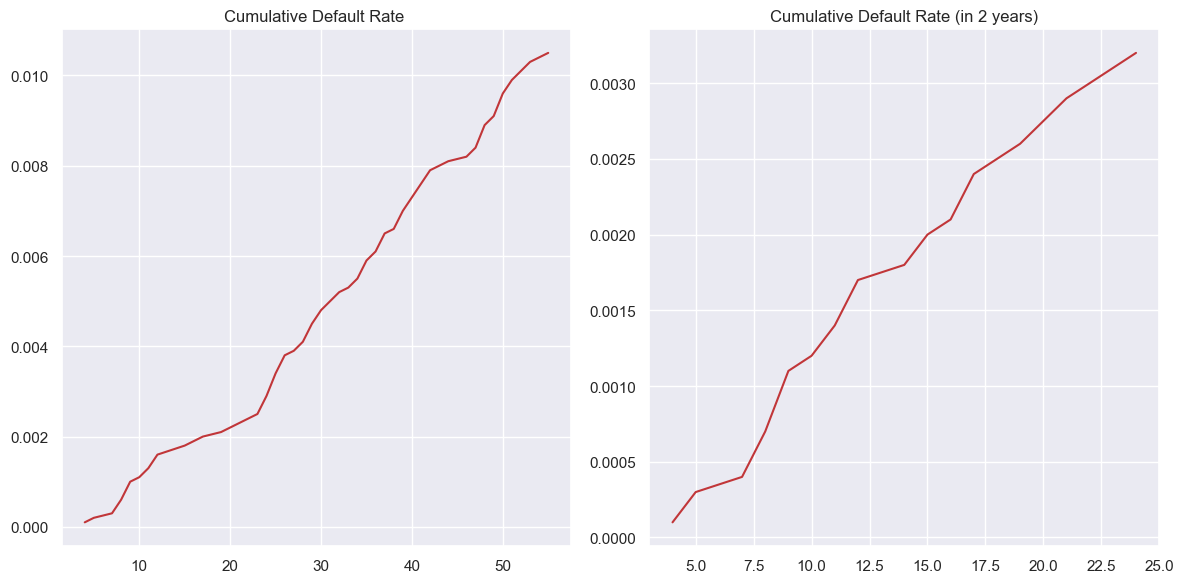

In [458]:
delinq["month_since_org"] = (delinq["perform_dt"] - delinq["orig_dt"]).apply(lambda x: x.days // 30)

# mark absorbing date
default_idx = delinq[isdefault].drop_duplicates(subset=["idx"], keep="first")
default2y_idx = delinq[isdefault & in2y].drop_duplicates(subset=["idx"], keep="first")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].plot(default_idx.groupby("month_since_org").size().cumsum()/n_bonds)
axes[0].set_title("Cumulative Default Rate ")

axes[1].plot(default2y_idx.groupby("month_since_org").size().cumsum()/n_bonds)
axes[1].set_title("Cumulative Default Rate (in 2 years)")

plt.tight_layout()
plt.show()

## Question 3
What fraction of loans that become 60 days past due on its payments resume making their payments (in other words become current again)

In [461]:
def filterCurrentBond(use_both_conditions=True):
    
    if use_both_conditions:
        once_default_idx =  delinq[isdefault & in2y].idx.unique().tolist()
    else:
        once_default_idx =  delinq[isdefault].idx.unique().tolist()


    # all historical records of default bonds
    once_default = delinq[delinq.idx.isin(once_default_idx)].copy()
    # keep only current and default status records
    default_current = once_default.loc[once_default.loc[:, "delinq_status"].isin([0.0, '0', '2'])].copy()
    default_current.sort_values(by=["idx", "month_since_org"], ascending=True, inplace=True)  # important for groupby diff

    # detect change in delinq status
    default_current["delinq_status"] = default_current["delinq_status"].astype(int)
    default_current.loc[:, "status_change"] = default_current.groupby("idx")["delinq_status"].apply(lambda x: x.diff())

    if use_both_conditions:
        print("Fraction of <loans that default in 2 years and become current again> in <all loans that default in 2 years>: ",
                f"{ len(default_current[default_current.status_change==-2].idx.unique()) / len(once_default_idx) * 100:.2f} %")
    else:
                print("Fraction of <all default that become current again> in <all default loans>: ",
                f"{ len(default_current[default_current.status_change==-2].idx.unique()) / len(once_default_idx) * 100:.2f} %")


In [459]:
filterCurrentBond(use_both_conditions=False)

Fraction of <all default that become current again> in <all default loans>:  71.43 %


In [462]:
filterCurrentBond(use_both_conditions=True)

Fraction of <loans that default in 2 years and become current again> in <all loans that default in 2 years>:  71.88 %
